In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats import weightstats

In [45]:
import seaborn

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

In [6]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [23]:
data.shape

(30000, 25)

In [9]:
data.isnull().sum().sum() # Есть ли пропуски в данных

0L

### 1 Задание

### a)

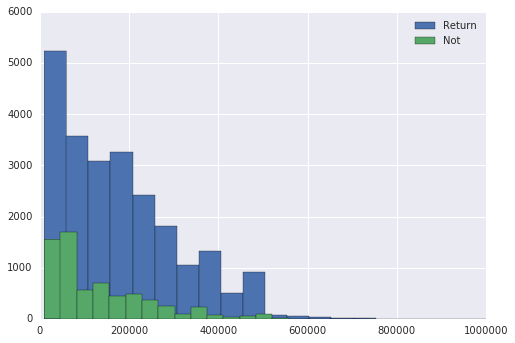

In [46]:
data.LIMIT_BAL[data.default==0].hist(label='Return', bins=20)
data.LIMIT_BAL[data.default==1].hist(label='Not',bins=20)
plt.legend()

Для оценки медианных значений, используем метод бутстреп<br>
Нулевая гипотеза: медианны равны.<br>
Альтернатива: значимо отличаються

In [27]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [32]:
ret_median = map(np.median,get_bootstrap_samples(data.LIMIT_BAL[data.default==0].values,1000))
not_median = map(np.median,get_bootstrap_samples(data.LIMIT_BAL[data.default==1].values,1000))

In [35]:
delta_median = map(lambda x: x[0] - x[1], zip(ret_median,not_median))

In [36]:
print "95% доверительный интервал для разности медиан",  stat_intervals(delta_median, 0.05)

95% доверительный интервал для разности медиан [ 60000.  70000.]


### b)

In [43]:
stats.mannwhitneyu(data.LIMIT_BAL[data.default==1][:1000],data.LIMIT_BAL[data.default==0][:1000],alternative='two-sided')

MannwhitneyuResult(statistic=428597.0, pvalue=2.8485090627266612e-08)

уже на первых 1000 обьектах, гипотеза о равенстве средних 2-х выборок отвергаеться.<br>
Эти данные практически очень значимы, так как мы понимаем, что большенство клиентов способны отдать кредит

### 2 Задание

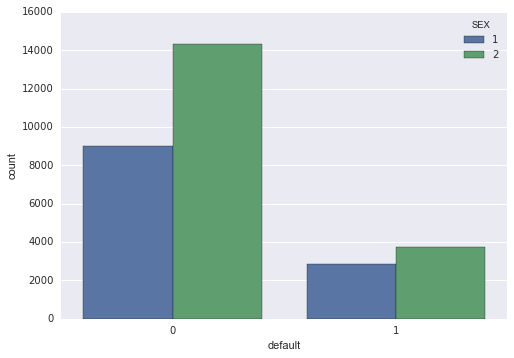

In [55]:
seaborn.countplot(x='default',data=data, hue='SEX')

#### Гипотеза:
    Доля вернувших кредит среди женщин = Среди мужчин
#### Альтернатива:
    Не равны 

In [76]:
def proportions_diff_z_stat_ind(sample1,sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [85]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = sp.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [78]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - sp.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return sp.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sp.stats.norm.cdf(z_stat)

In [74]:
women = data[data.default==0].loc[data.SEX ==2].shape[0]*[1] + \
        data[data.default==1].loc[data.SEX ==2].shape[0]*[0]
men = data[data.default==0].loc[data.SEX ==1].shape[0]*[1] + \
      data[data.default==1].loc[data.SEX ==1].shape[0]*[0]

In [82]:
print 'Достигаемый уровень значимости для разности доли вернувших кредит женщин и мужчин:'
print 'p_value: ',proportions_diff_z_test(proportions_diff_z_stat_ind(women,men),'two-sided')

Достигаемый уровень значимости для разности доли вернувших кредит женщин и мужчин:
p_value:  4.47286652161e-12


In [86]:
print 'Доерительный интервал: [%f, %f]' % proportions_confint_diff_ind(women, men)

Доерительный интервал: [0.024207, 0.043612]


In [88]:
women = np.array(women)
men = np.array(men)

In [89]:
len(women)

18112

In [90]:
binom_table = pd.DataFrame([[women.sum(),len(women) - women.sum()],
                           [men.sum(),len(men) - men.sum()]],dtype=np.float)

In [91]:
binom_table.columns = ['default=0','default=1']
binom_table.index = ['women','men']
binom_table

,default=0,default=1
women,14349.0,3763.0
men,9015.0,2873.0


In [92]:
def MMC(x): 
    TP = x.ix[0,0]
    TN = x.ix[1,1]
    FN = x.ix[0,1]
    FP = x.ix[1,0]
    return (TP*TN - FP*FN)/ np.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN))

In [118]:
mmc = MMC(binom_table)
mmc

0.039960577705441591

Судя по кореляции Метьюса, гендерный признак ни как не влияет<br>
Значимо ли отличаеться корреляция Метьюса от 0?

In [122]:
stat,p,__,__ = stats.chi2_contingency(binom_table)
print 'P_value = ', p

P_value =  4.94467899941e-12


### 3 Задание

In [98]:
default = data.default.value_counts().keys()

In [99]:
columns = ['0 = доктор','1 = магистр','2 = бакалавр','3 = выпускник школы',
           '4 = начальное образование', '5= прочее', '6 = нет данных'] 
columns = np.array(columns)

In [103]:
arr = np.zeros([default.size,columns.size],dtype=np.float)

In [112]:
for i in range(default.size):
    for j in range(columns.size):
        arr[i,j] = data[data.default == i].loc[data.EDUCATION == j].shape[0]

In [113]:
edu_table = pd.DataFrame(arr)
edu_table.columns = columns
edu_table.index = ['Defalut = %s' % str(x) for x in default]

In [114]:
edu_table

,0 = доктор,1 = магистр,2 = бакалавр,3 = выпускник школы,4 = начальное образование,5= прочее,6 = нет данных
Defalut = 0,14.0,8549.0,10700.0,3680.0,116.0,262.0,43.0
Defalut = 1,0.0,2036.0,3330.0,1237.0,7.0,18.0,8.0


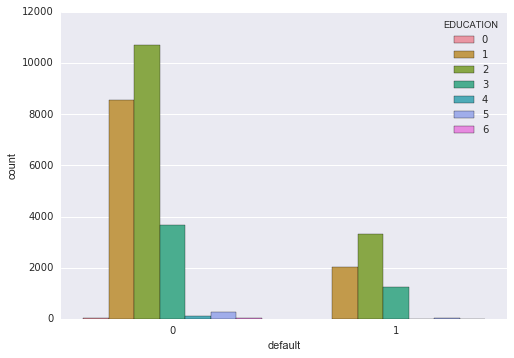

In [123]:
seaborn.countplot(x='default',data=data,hue='EDUCATION')

Перед использованием критераия Хи2, необходимо улостовериться, что ожидаемое кол-во элементов в кажой ячейке меньеше 5-и, не более чем в 20% ячеек

In [130]:
def check_cells_for_chi2(table):
    __,__,__,expecte = stats.chi2_contingency(table)
    return np.sum(expecte < 5) / (table.shape[0]*table.shape[1]) > 0.2

In [131]:
check_cells_for_chi2(edu_table)# Если False, значит не больше 20%

False

Значимо ли отличаеться кореляция выплаты кредита и образовния от 0?

In [133]:
edu_stat, p_edu_value,__, expected_edu = stats.chi2_contingency(edu_table)

In [134]:
print 'Достигамый уровень значимости: ',p_edu_value

Достигамый уровень значимости:  1.23326262454e-32


Коофициент Крамера:

In [139]:
v_kramer = np.sqrt(edu_stat / (edu_table.sum().sum() * \
                               (min(edu_table.shape[0],edu_table.shape[1]) - 1.0)))
v_kramer

0.073760097132521629

Разница между наблюдаемым и ожидаемым значениями

In [135]:
edu_table - expected_edu

,0 = доктор,1 = магистр,2 = бакалавр,3 = выпускник школы,4 = начальное образование,5= прочее,6 = нет данных
Defalut = 0,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
Defalut = 1,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


Видно, что человек с образованием "Бакалавр" или "Выпускник школы" скорее всего не отдаст кредит

### 4 Задание

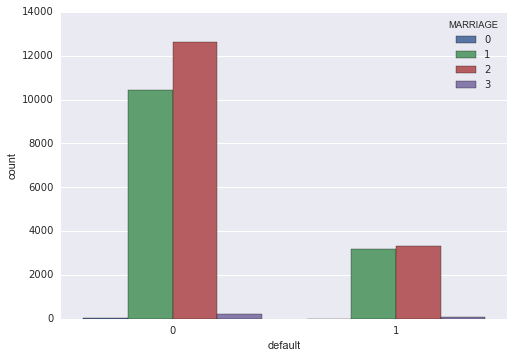

In [140]:
seaborn.countplot(x='default',data=data,hue='MARRIAGE')

In [142]:
marriage = np.array(['0 = отказываюсь отвечать', '1 = замужем/женат', '2 = холост', '3 = нет данных'])
arr = np.zeros([default.size,marriage.size])
for i in range(default.size):
    for j in range(marriage.size):
        arr[i,j] = data[data.default == i].loc[data.MARRIAGE == j].shape[0]
marr_table = pd.DataFrame(arr)
marr_table.columns = marriage
marr_table.index = ['Defalut = %s' % str(x) for x in default]

In [143]:
marr_table

,0 = отказываюсь отвечать,1 = замужем/женат,2 = холост,3 = нет данных
Defalut = 0,49.0,10453.0,12623.0,239.0
Defalut = 1,5.0,3206.0,3341.0,84.0


Судя по графику, есть необходимость проверить на ожиемость

In [146]:
check_cells_for_chi2(marr_table)

False

Анннет... Все нормально и можно использовать Хи2<br>
Для вычисления связи между обучением и возвратом стоит использовать значение Крамера

In [152]:
marr_stat,__,__,__ = stats.chi2_contingency(marr_table)

In [153]:
v_kramer = np.sqrt(marr_stat / (marr_table.sum().sum() * \
                               (min(marr_table.shape[0],marr_table.shape[1]) - 1.0)))

In [154]:
print 'Значение кармера для свзи между образованием и возвратом: ', v_kramer

Значение кармера для свзи между образованием и возвратом:  0.0344782036628


### 5 Задание

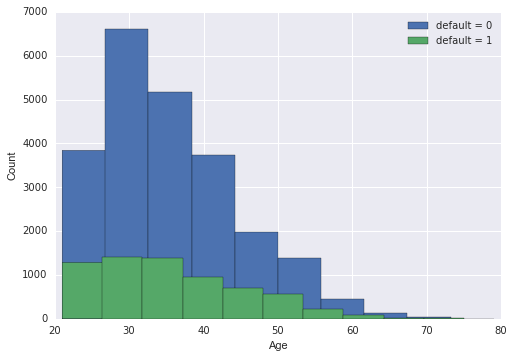

In [165]:
data.AGE[data.default==0].hist(label='default = 0')
data.AGE[data.default==1].hist(label='default = 1')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

Гипотеза: разница медиан = 0<br>
Для проверки этой гипотезы, воспользуемся методом bootstrap

In [180]:
age_def0 = data.AGE.loc[data.default==0].values
age_def1 = data.AGE.loc[data.default==1].values

In [182]:
age_def0

array([34, 37, 57, ..., 38, 39, 43], dtype=int64)

In [175]:
age_def0_median = map(np.median,get_bootstrap_samples(age_def0,1000))
age_def1_median = map(np.median,get_bootstrap_samples(age_def1,1000))

In [176]:
delta_age_median = map(lambda x: x[0] - x[1], zip(age_def0_median,age_def1_median))

In [177]:
print '95% интеравал для разности медиан: ',stat_intervals(delta_age_median,0.05)

95% интеравал для разности медиан:  [-1.  0.]


0 входит в интервал

Воспользуемся критерием Манна-Уитни для проверки гипотезы о равенсте средних

In [181]:
stats.mannwhitneyu(age_def1,age_def0)

MannwhitneyuResult(statistic=76966879.5, pvalue=nan)

Критерий Манна - уитни отвергает гипотезу о равенстве<br>
Используем перестановочный критерий, который обладает большей мощностью

In [183]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [186]:
print 'P-value = ', permutation_test(age_def0,age_def1,max_permutations=1000)

 P-value =  0.016


Видно что гипотеза все равно отвергаеться... Все из-за того, что распределние имеет очень тяжелый хвост